In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('../input/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [2]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


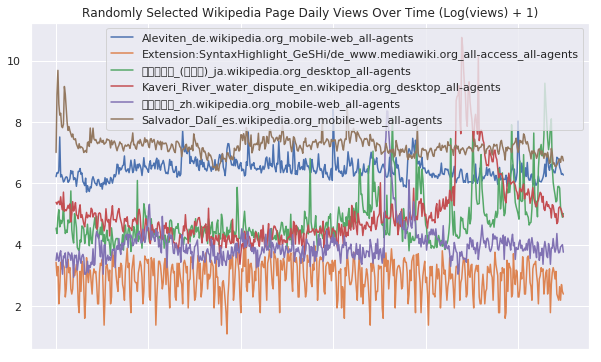

In [3]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

In [4]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [5]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-09-02 00:00:00
Train prediction: 2016-09-03 00:00:00 - 2016-11-01 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2016-11-01 00:00:00
Val prediction: 2016-11-02 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 430
Prediction interval: 60


In [6]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [7]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

## ALTRI PARAMETRI
# n_filters = 128
# filter_width = 5
# dilation_rates = [2**i for i in range(12)]

# # define an input history series and pass it through a stack of dilated causal convolutions
# history_seq = Input(shape=(None, 1))
# x = history_seq

# for dilation_rate in dilation_rates:
#     x = Conv1D(filters = n_filters,
#                kernel_size=filter_width,
#                padding='causal',
#                dilation_rate=dilation_rate)(x)
#     # for Dense Layer:
#     # Input shape
#     # nD tensor with shape: (batch_size, ..., input_dim). The most common situation would be a 2D input with shape (batch_size, input_dim).
#     #
#     # Output shape
#     # nD tensor with shape: (batch_size, ..., units).
#     # For instance, for a 2D input with shape  (batch_size, input_dim), the output would have shape (batch_size, units).
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(.8)(x)
#     x = Dense(64)(x)
#     x = Dense(1)(x)



# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2 #2 
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [8]:
first_n_samples = 120000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 96000 samples, validate on 24000 samples
Epoch 1/10
96000/96000 [==============================] - 147s 2ms/step - loss: 0.4432 - val_loss: 0.2816
Epoch 2/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2973 - val_loss: 0.2650
Epoch 3/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2840 - val_loss: 0.2562
Epoch 4/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2771 - val_loss: 0.2525
Epoch 5/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2737 - val_loss: 0.2500
Epoch 6/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2716 - val_loss: 0.2483
Epoch 7/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2703 - val_loss: 0.2473
Epoch 8/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2693 - val_loss: 0.2464
Epoch 9/10
96000/96000 [==============================] - 125s 1ms/step - loss: 0.2681 - val_loss: 0.2

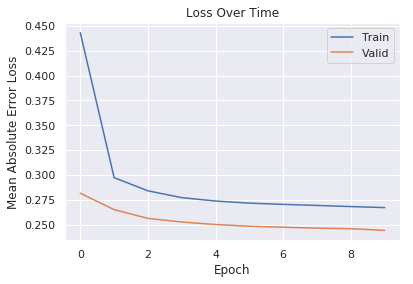

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [10]:
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [11]:
encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)

    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    print('Sample ind', sample_ind,'Test Mean Absolute Error :', mean_absolute_error(target_series,pred_series))  
    print('Smape = ',smape(target_series, pred_series))
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='teal')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='orange')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Sample ind 16534 Test Mean Absolute Error : 0.16196220618026566
Smape =  69.33944191604883
Sample ind 16555 Test Mean Absolute Error : 0.14428715928283886
Smape =  101.52976761667006
Sample ind 4000 Test Mean Absolute Error : 0.43391450965383854
Smape =  24.31241475295937
Sample ind 68000 Test Mean Absolute Error : 0.21646095765072743
Smape =  99.01714442257604
Sample ind 6007 Test Mean Absolute Error : 0.24373297912414227
Smape =  138.80588558370266
Sample ind 70450 Test Mean Absolute Error : 0.09686463237336765
Smape =  30.343806587902545


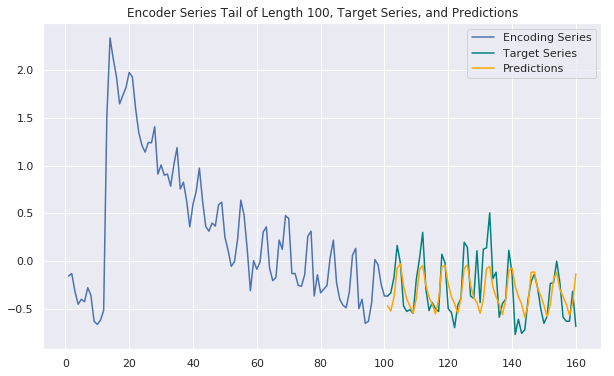

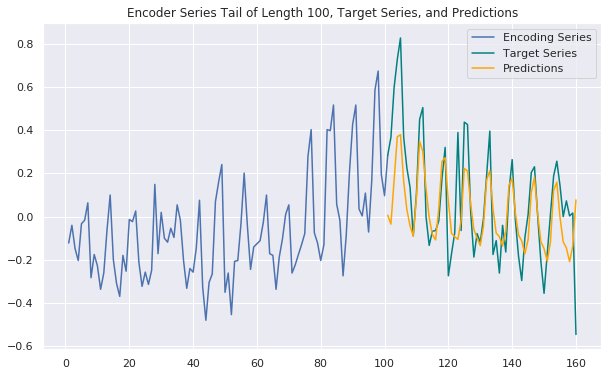

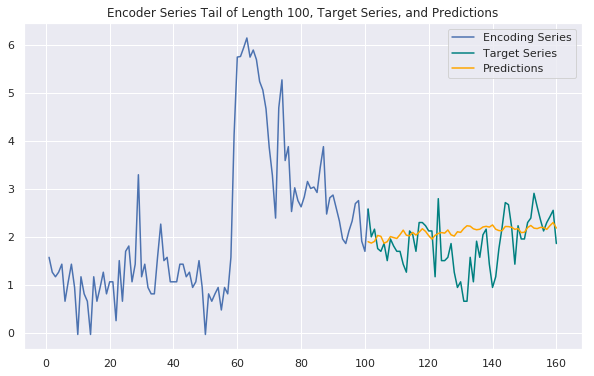

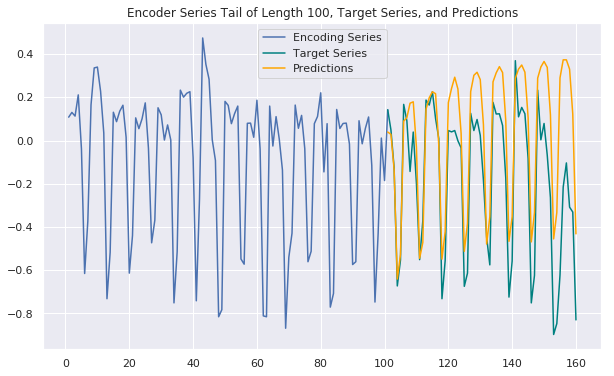

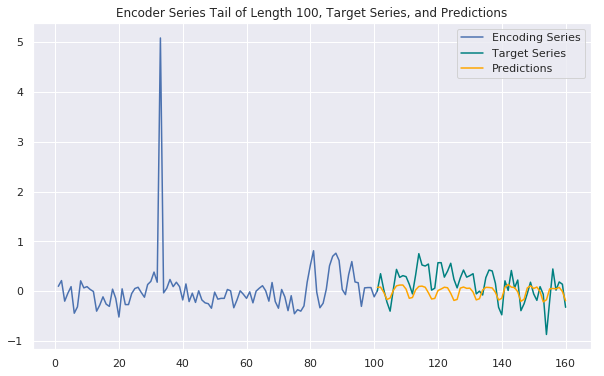

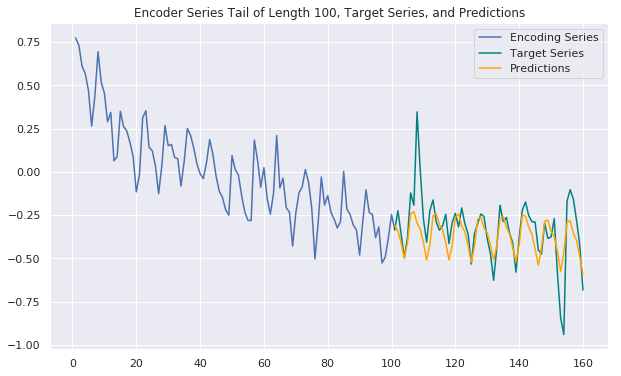

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=16534, enc_tail_len=100)
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=16555, enc_tail_len=100)
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=4000, enc_tail_len=100)

predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=68000, enc_tail_len=100)

predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=6007, enc_tail_len=100)
predict_and_plot(encoder_input_data, decoder_target_data,sample_ind=70450, enc_tail_len=100)

In [14]:
# predict_and_plot(encoder_input_data, decoder_target_data, 100)
# predict_and_plot(encoder_input_data, decoder_target_data, 6007)
# predict_and_plot(encoder_input_data, decoder_target_data, 33000)
# predict_and_plot(encoder_input_data, decoder_target_data, 110005)
# predict_and_plot(encoder_input_data, decoder_target_data, 70000)